In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

### Reading in flare data for GJ1243 from Davenport et al (2014)

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

In [3]:
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

### Importing in GJ1243 light curve (DR-25)

In [4]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

In [5]:
gj1243lc = gj1243_collection[0].PDCSAP_FLUX

for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX)
    except:
            print(q)

### Masking out the flares

In [6]:
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5 #play with these buffers 
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)

[False False False ... False False False]


Text(0, 0.5, 'Normalized Flux')

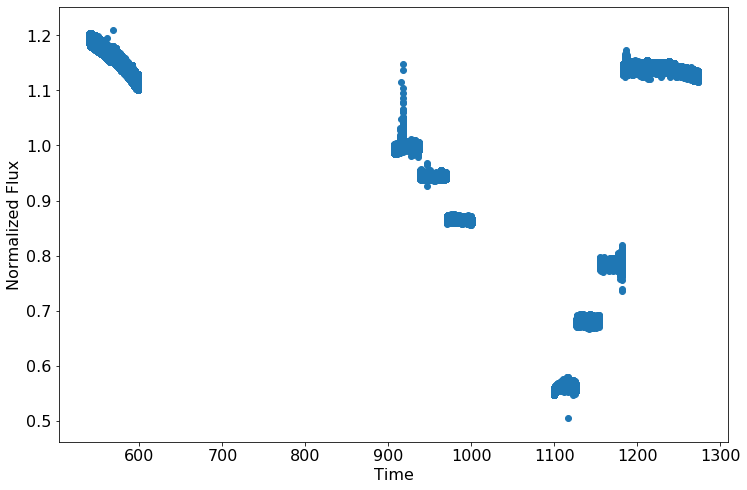

In [7]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

no_flares = np.where((f_mask == False))[0]
plt.scatter(gj1243lc.time[no_flares],gj1243lc.flux[no_flares]/np.nanmedian(gj1243lc.flux[no_flares]))
#plt.xlim(539.4,540.4)
#plt.ylim(1.17,1.22)
#plt.xlim(1190,1200)
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

In [8]:
extra_flares_table=pd.read_csv('extra_flares',skiprows=3,delim_whitespace=True,names=['t_start','t_stop'])
t_starts_extra=extra_flares_table.loc[:,'t_start']
t_stops_extra=extra_flares_table.loc[:,'t_stop']
#first one might be outlier
extra_flares_table

,t_start,t_stop
0,567.70,567.80
1,913.50,913.60
2,917.90,918.00
3,946.00,946.10
4,1178.80,1178.90
5,1181.58,1181.65
6,1185.50,1185.58


In [9]:
flares_x=gj1243lc.time[f_mask]
flares_y = gj1243lc.flux[f_mask]/np.nanmedian(gj1243lc.flux)

In [10]:
un_mes=gj1243_collection[0].PDCSAP_FLUX
f_mask_un_mes = np.zeros_like(un_mes.time, dtype=bool)

#mask array for one month of data
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0. #was.25 & .5
    c2 = 0. #play with these buffers 
    buffer = (un_mes.time >= (t_starts[i] - c1*dur)) & (un_mes.time <= (t_stops[i] + c2*dur))
    temp = (un_mes.time >= t_starts[i]) & (un_mes.time <= t_stops[i])
    f_mask_un_mes = f_mask_un_mes + buffer
print(f_mask_un_mes)
no_flare_un_mes = np.where((f_mask_un_mes == False))[0]

[False False False ...  True False False]


In [11]:
no_flare_un_mes

array([    0,     1,     2, ..., 39623, 39628, 39629])

### Light curve with highlighted flares

Text(0.5, 0, 'Time - 2457000 [BTJD days]')

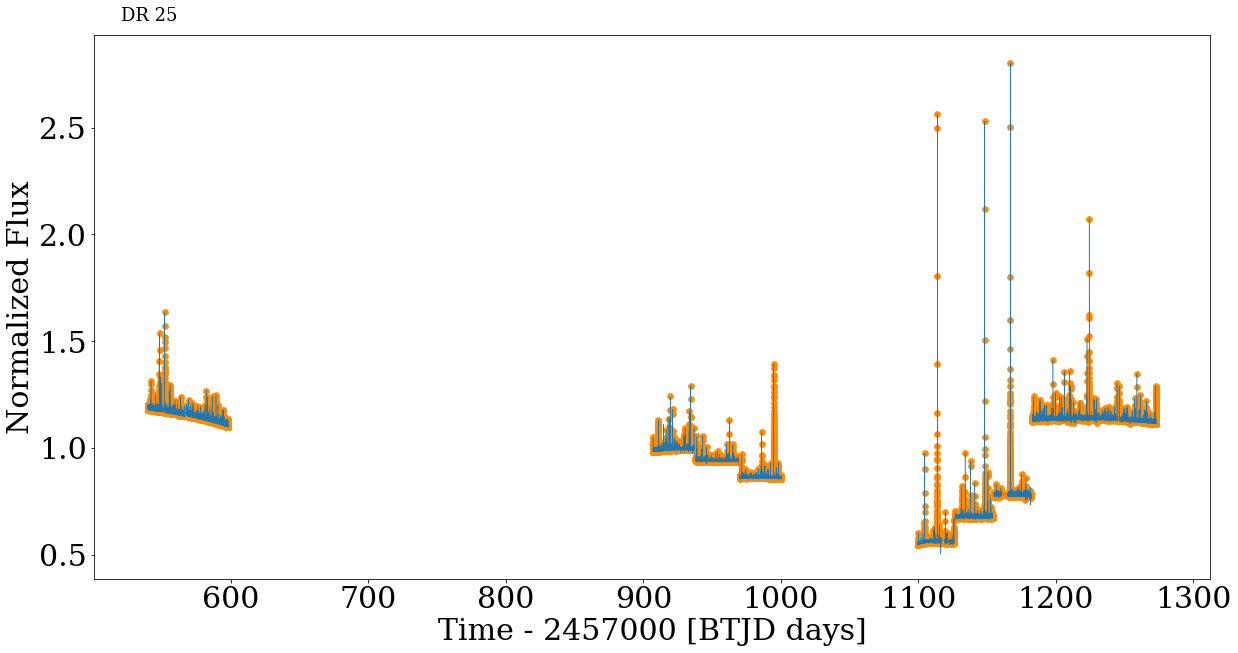

In [12]:
fig = plt.figure(figsize=(20,10))
import matplotlib
matplotlib.rcParams.update({'font.size':30})
matplotlib.rcParams.update({'font.family':'serif'})

fig.subplots_adjust(hspace=0.3, wspace=0.4)



plt.plot(gj1243lc.time[:84887],gj1243lc.flux[:84887]/np.nanmedian(gj1243lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243lc.time[84888:217976],gj1243lc.flux[84888:217976]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243lc.time[217976:],gj1243lc.flux[217976:]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)


plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)




#Text
plt.text(520, 3, 'DR 25', fontsize=18, color ='k')



#fig.text(0.06, 0.5, 'Normalized Flux', ha='center', va='center', rotation='vertical')
#fig.text(0.5, 0.05, 'Time - 2457000 [BTJD days]', ha='center', va='center')

plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")


#plt.savefig('gj1243_keplerlc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

### Accounting for quarterly discontinuities

In [13]:
#month1 = 1+((gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes] - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes]))/(np.nanmedian(gj1243lc.flux[no_flares])))
#month2 = 1+((gj1243_collection[1].PDCSAP_FLUX.flux[no_flare_un_mes]  - np.nanmedian(gj1243_collection[1].PDCSAP_FLUX.flux[no_flare_un_mes] ))/(np.nanmedian(gj1243lc.flux[no_flares] )))
#month3 = 1+((gj1243_collection[2].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[2].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))
#month4 = 1+((gj1243_collection[3].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[3].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))

In [63]:
i = 0
month1_median = np.nanmedian(gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes])
total_median = np.nanmedian(gj1243lc.flux[no_flares])

month1_flux = 1 + (gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes] - month1_median) / total_median

raw_flux = 1+((gj1243_collection[0].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes]))/(np.nanmedian(gj1243lc.flux)))

In [40]:
#WORK ON THIS

#this_month = np.where(gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time) & (gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))
#gj1243_collection[0].time[no_flares[this_month]]

In [41]:
medflux=np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        med = 1+((gj1243_collection[i].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[i].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))
        medflux = np.append(medflux,med)
    except:
            print(i)

(0.9, 1.2)

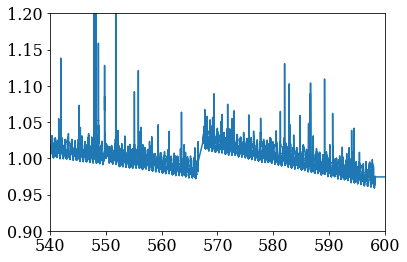

In [42]:
plt.plot(gj1243lc.time,medflux)
plt.xlim(540,600)
plt.ylim(0.9,1.2)

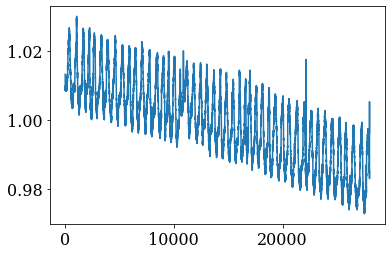

In [44]:
plt.plot(month1_flux)

In [46]:
print(len(un_mes.flux))#not averaged
print(len(month1_flux)) #has the correct averaging for flareless data

39630
28000


### GP

In [47]:
import celerite
y = month1_flux
t = un_mes.time[no_flare_un_mes]
yerr = 1+((gj1243_collection[0].PDCSAP_FLUX.flux_err[no_flare_un_mes] - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[no_flare_un_mes]))/(np.nanmedian(gj1243lc.flux[no_flare_un_mes])))
yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)
#fix avg for y &yerr

# A non-periodic component
Q = 0.001
w0 = 2*np.pi/0.59
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)
#kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

In [48]:
gj1243_collection[0].PDCSAP_FLUX.flux_err

array([83.01843 , 82.97698 , 82.96462 , ..., 79.520004, 78.98069 ,
       78.729614], dtype=float32)

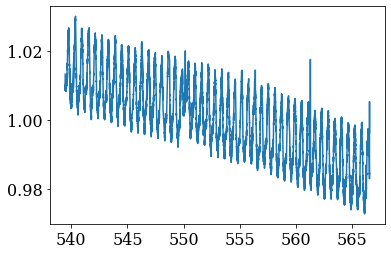

In [49]:
plt.plot(t,y)

<ErrorbarContainer object of 3 artists>

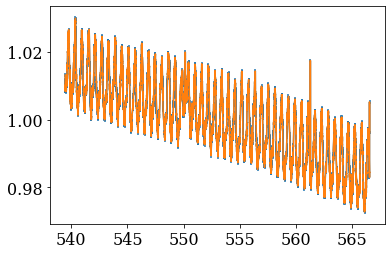

In [50]:
plt.errorbar(t,y,yerr=yerr)
plt.errorbar(t,y)

In [51]:
gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

Initial log likelihood: 126498.12167499245
parameter_dict:
OrderedDict([('kernel:log_S0', -4.375628587868117), ('kernel:log_Q', -6.907755278982137), ('kernel:log_omega0', 2.3655098084917174), ('mean:value', 0.999515950679779)])

parameter_names:
('kernel:log_S0', 'kernel:log_Q', 'kernel:log_omega0', 'mean:value')

parameter_vector:
[-4.37562859 -6.90775528  2.36550981  0.99951595]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (None, None)]



In [52]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)


      fun: -167922.37519706547
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.76252036, -0.13387762,  0.23283064,  0.        ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 155
      nit: 26
   status: 0
  success: True
        x: array([-3.28164954, -3.02254714,  0.69309244,  1.00937299])


In [61]:
#running pred_var takes a long time
x= un_mes.time
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [53]:
gp_vals=pd.read_csv('gp_values_1mo.csv')

In [26]:
#gp_vals #(time,mean,std,var)

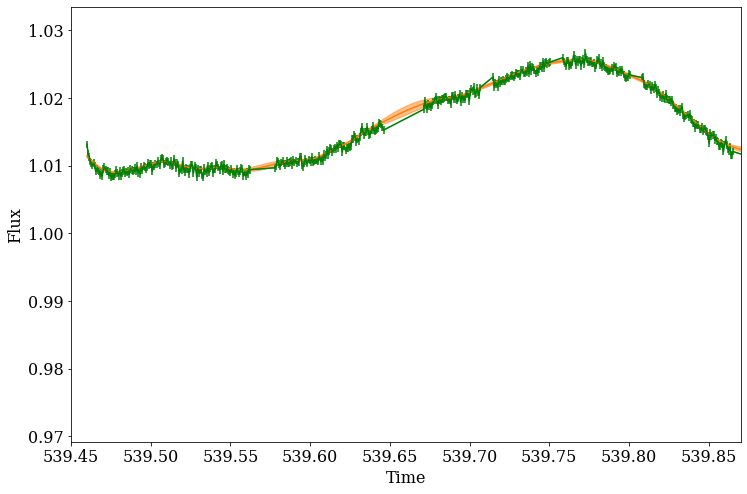

In [54]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

color = "#ff7f0e"
#plt.plot(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux),  lw=1, alpha=0.5)
plt.errorbar(t, y, yerr=yerr, color='g')
plt.plot(gp_vals['time'], gp_vals['mean'], color=color)
plt.fill_between(gp_vals['time'], gp_vals['mean']+gp_vals['std'], gp_vals['mean']-gp_vals['std'], color=color, alpha=0.5,
                 edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")
#plt.xlim(539.5,565)
plt.xlim(539.45,539.870)
#plt.ylim(-2.5, 2.5);


plt.plot(un_mes.time[no_flare_un_mes],month1_flux, lw=1,alpha=0.5)

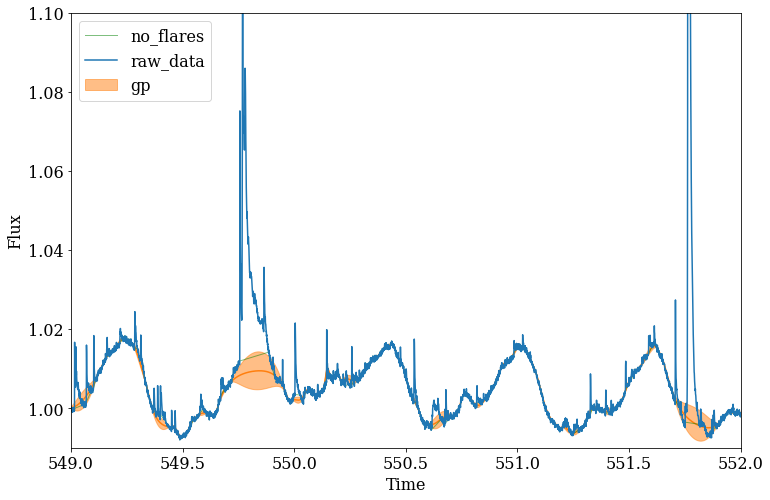

In [64]:
# A zoom in on just one month of the gp
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

color = "#ff7f0e"
#plt.plot(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux),  lw=1, alpha=0.5)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(gp_vals['time'], gp_vals['mean'], color=color)
plt.fill_between(gp_vals['time'], gp_vals['mean']+gp_vals['std'], gp_vals['mean']-gp_vals['std'], color=color, alpha=0.5,
                 edgecolor="none",label='gp')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.xlim(549,552)
#plt.xlim(539.45,539.870)
plt.ylim(0.99,1.1)
plt.plot(un_mes.time[no_flare_un_mes],month1_flux, lw=1,alpha=0.5,color='g',label='no_flares')
plt.plot(un_mes.time,raw_flux
        ,label='raw_data')
plt.legend()

### Saving gp outputs for Q1 to .csv file

In [27]:
# dictionary of lists  
# will not run w/o running the gp first 
dict = {'time':x,'mean': pred_mean, 'std': pred_std, 'var': pred_var}  
gp_out = pd.DataFrame(dict) 
gp_out.to_csv(r'/Users/lupitatovar/flares/notebooks/gp_values_1mo.csv',header=True,index=True)

NameError: name 'x' is not defined

### Fixing quarterly discontinuties

In [28]:
plt.plot(x,pred_mean)

NameError: name 'x' is not defined

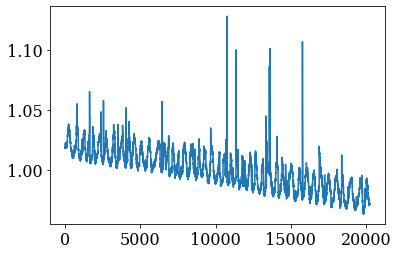

In [29]:
#plt.plot(x,month1-pred_mean, color=color)
#plt.plot(month1)
plt.plot(month2)
#plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.5,
                 #edgecolor="none")

### Sample of Flares to stack
#### Criteria:
- 20-75 minutes duration
- no complex flares

In [29]:
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [30]:
#flare_table

In [31]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641


In [32]:
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

#classic_flare_dur = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur])

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


902

### Stacking the Flares for one month

Stack the flares just in the first month (for now)

Plot [x,y] where x = time - peak time/ (t_(1/2) 

Y = detrended data / peak amplitude 

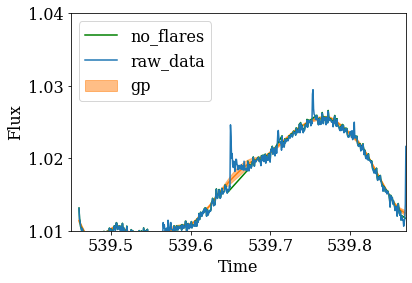

In [65]:
#zoom in on the first classical flare in the first quarter of data

oneflare_x = gj1243_collection[0].time
#oneflare_y = 1+((gj1243_collection[0].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux)))
#plt.plot(oneflare_x,oneflare_y)
#plt.plot(gj1243_collection[0].time[f_mask_un_mes],
         #1+((gj1243_collection[0].PDCSAP_FLUX.flux[f_mask_un_mes] - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux[f_mask_un_mes]))/(np.nanmedian(gj1243lc.flux))), 
         #color='orange', alpha=0.5)

#plt.xlim(539.646668,539.671143)
plt.xlim(539.45,539.870)
plt.ylim(1.01,1.04)
plt.plot(gp_vals['time'], gp_vals['mean'], color=color)
plt.fill_between(gp_vals['time'], gp_vals['mean']+gp_vals['std'], gp_vals['mean']-gp_vals['std'], color=color, alpha=0.5,
                 edgecolor="none",label='gp')
plt.xlabel("Time")
plt.ylabel("Flux")

plt.plot(un_mes.time[no_flare_un_mes],month1_flux,color='g',label='no_flares')
plt.plot(un_mes.time,raw_flux,label='raw_data')
plt.legend()

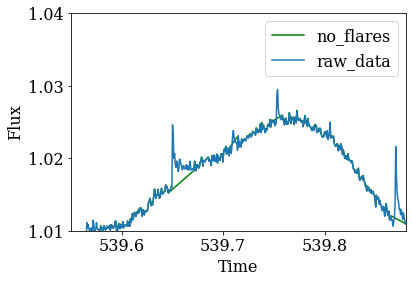

In [66]:
plt.xlim(539.55,539.88)
plt.ylim(1.01,1.04)
plt.xlabel("Time")
plt.ylabel("Flux")

plt.plot(un_mes.time[no_flare_un_mes],month1_flux,color='g',label='no_flares')
plt.plot(un_mes.time,raw_flux,label='raw_data')
plt.legend()

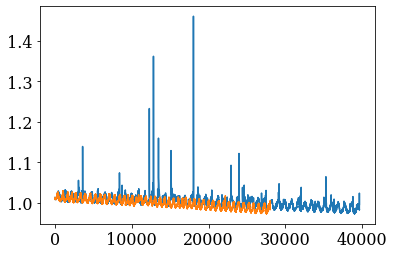

In [67]:
plt.plot(raw_flux,label='raw_data')
plt.plot(month1)

#could it be buffer added to the start/end of the flares that is causing the offset?

flare-less data matches with the gp but there is an offset with the raw data still..

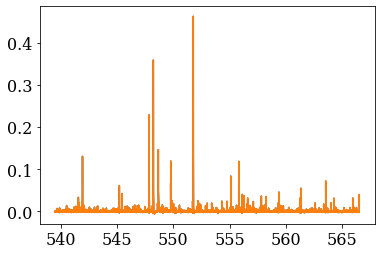

In [68]:
detrended_unmes = (1+((gj1243_collection[0].PDCSAP_FLUX.flux - np.nanmedian(gj1243_collection[0].PDCSAP_FLUX.flux))/(np.nanmedian(gj1243lc.flux))))-gp_vals['mean']
plt.plot(gp_vals['time'],detrended_unmes)
plt.plot(un_mes.time,detrended_unmes)
#plt.xlim(539,540)
#plt.ylim(-0.01,0.01)

(539.5, 550)

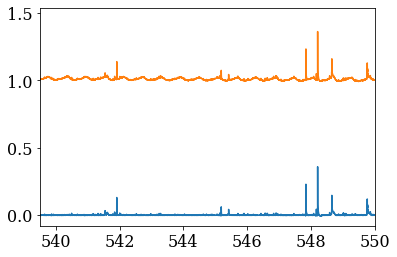

In [69]:
#comparing the data w/ (orange) and w/o the starspot (blue)
plt.plot(gp_vals['time'],detrended_unmes)
plt.plot(gp_vals['time'],oneflare_y)
plt.xlim(539.5,550)

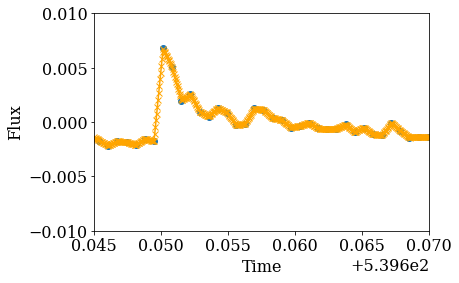

In [70]:
#subtracting the gp

plt.scatter(oneflare_x,detrended_unmes)
#avg that includes the flares

#plt.xlim(539.646668,539.671143)
plt.xlim(539.645,539.670)
plt.ylim(-.01,0.01)

#plt.plot(x, pred_mean, color=color)
#plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.5,
                 #edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")

xvals = np.linspace(539.645, 539.67, 500)
yinterp = np.interp(xvals, oneflare_x, detrended_unmes)
plt.plot(xvals,yinterp,'-x',color='orange')

In [71]:
#flux position of t_half
print((classical_flares.t_peak[1] - classical_flares.t_start[1])/2)

print((classical_flares.t_peak[1] - classical_flares.t_stop[1])/2)

#time position of t_half
print((classical_flares.t_peak[1] + classical_flares.t_start[1])/2)

0.0016784499999857871
-0.010559100000023136
539.64834595


In [72]:
classical_flares.t_start[1]

539.6466675

In [73]:
#def t_half(t1, tp):
    #return Point((t1[0]+tp[0])/2, (t1[1]+tp[1])/2)

In [74]:
peak = max(yinterp)  # Find the maximum y value
xs = [x for x in range(500) if yinterp[x] > peak/2.0]
print(min(xs), max(xs)) # Print the points at half-maximum

98 123


In [75]:
print(yinterp[98])
print(yinterp[123])

0.003928015098724153
0.0035028304141460458


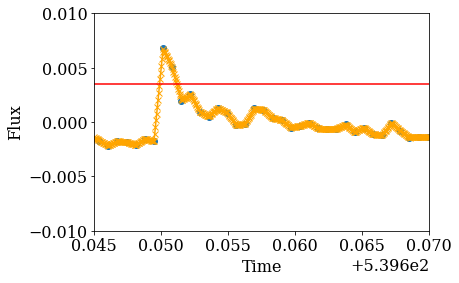

In [76]:
#subtracting the gp

plt.scatter(oneflare_x,detrended_unmes)
#avg that includes the flares

#plt.xlim(539.646668,539.671143)
plt.xlim(539.645,539.670)
plt.ylim(-.01,0.01)

#plt.plot(x, pred_mean, color=color)
#plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.5,
                 #edgecolor="none")
plt.xlabel("Time")
plt.ylabel("Flux")

xvals = np.linspace(539.645, 539.67, 500)
yinterp = np.interp(xvals, oneflare_x, detrended_unmes)
plt.plot(xvals,yinterp,'-x',color='orange')
plt.axhline(y=yinterp[123], color='r', linestyle='-')

Text(0, 0.5, 'Relative Flux')

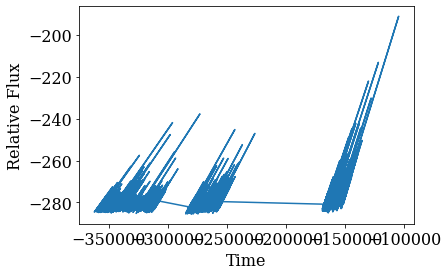

In [81]:
# t_half = half of the max (peak)
# similar to fwhm on photometry
x_stack = (classical_flares['Flare_Duration'] - classical_flares['t_peak']) / yinterp[123]
y_stack = x_stack / classical_flares['t_peak']
plt.plot(x_stack,y_stack)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
# peak time is in the fbeye file (that is what is used for Jim's plot)
# peak amplitude (also in the fbeye file but we want to calculate it for future work)


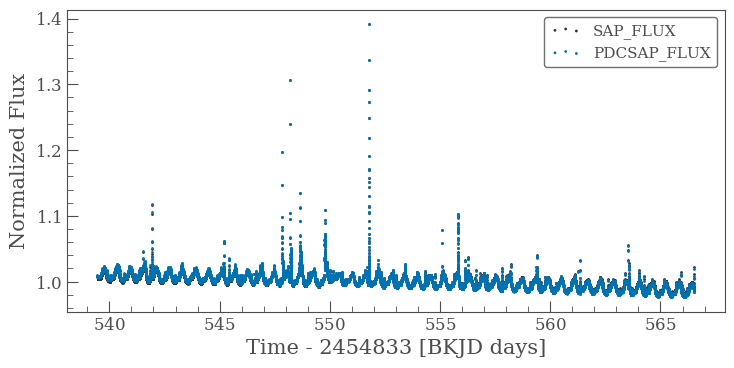

In [41]:
gj1243_collection[0].scatter()

In [42]:
#first quarter of flares runs from times ~539-567
q1_flares = classical_flares[classical_flares['t_stop'] < 567]
print(len([i for i in classical_flares['t_stop'] if i < 567]))
print(len(q1_flares))

486
486


In [ ]:
q1flares2stack=[]
for i in classical_flares['Flare_Duration']:
    if i >=min_dur and i <max_dur:
        flares2stack.append()
print(flares2stack)